In [1]:
#!/usr/bin/env python3

import autograd.numpy as np
import matplotlib.pyplot as plt
import random as rd
from mpl_toolkits.mplot3d import Axes3D
from sklearn.utils import check_random_state
from scipy.stats import multivariate_normal
from scipy.stats import norm
import time
from sklearn.utils import check_random_state
import kgof
import kgof.data as data
import kgof.density as density
import kgof.goftest as gof
import kgof.kernel as kernel
import kgof.util as util
from functools import partial
from module_hist import *


In [2]:
def _sample_parameter_U(n_samples, n_dim, random_state=None):
    """Sample the U parameters of a Riemannian Gaussian distribution.
    Sample the eigenvectors of a SPD matrix following a Riemannian Gaussian
    distribution.
    See https://arxiv.org/pdf/1507.01760.pdf for the mathematical details.
    Parameters
    ----------
    n_samples : int
        How many samples to generate.
    n_dim : int
        Dimensionality of the SPD matrices to be sampled.
    random_state : int, RandomState instance or None, default=None
        Pass an int for reproducible output across multiple function calls.
    Returns
    -------
    u_samples : ndarray, shape (n_samples, n_dim)
        Samples of the U parameters of the Riemannian Gaussian distribution.
    """

    u_samples = np.zeros((n_samples, n_dim, n_dim))
    rs = check_random_state(random_state)
    for i in range(n_samples):
        A = rs.randn(n_dim, n_dim)
        Q, _ = np.linalg.qr(A)
        u_samples[i] = Q

    return u_samples

In [3]:
start2 = time.time()

def frequence(t):
    return 0.01265*t**3 - 0.1648*t**2 + 0.7145*t-0.03374

def frequence_marge(t):
    if t<=0.3:
        return 0.02
    else:
        return 0.01265*t**3 - 0.1648*t**2 + 0.7145*t-0.15


def rejection_sampling_A(sigma, r):
    MU_A = np.array([sigma**2/2, -sigma**2/2])
    COV_MATRIX = (sigma**2)*np.eye(2)
    M = np.pi*(sigma**2)*np.exp(sigma**2/4)
    if r[0] >= r[1]:
        M = np.pi*(sigma**2)*np.exp(sigma**2/4)
        num = np.exp(-1/(2*sigma**2) * np.sum(r**2)) * np.sinh((r[0] - r[1])/2) * 1/M
        den = multivariate_normal.pdf(r, mean=MU_A, cov=COV_MATRIX)
        return num / den
    return 0
    
def rejection_sampling_B(sigma, r):
    MU_B = np.array([-sigma**2/2, sigma**2/2])
    COV_MATRIX = (sigma**2)*np.eye(2)
    M = np.pi*(sigma**2)*np.exp(sigma**2/4)
    if r[0] < r[1]:
        M = np.pi*(sigma**2)*np.exp(sigma**2/4)
        num = np.exp(-1/(2*sigma**2) * np.sum(r**2)) * np.sinh((r[1] - r[0])/2)
        den = multivariate_normal.pdf(r, mean=MU_B, cov=COV_MATRIX)*M
        return num/den
    return 0

def rejection_sampling_long(sigma, n, random_state=None):
    MU_A = np.array([sigma**2/2, -sigma**2/2])
    MU_B = np.array([-sigma**2/2, sigma**2/2])
    COV_MATRIX = (sigma**2)*np.eye(2)
    M = np.pi*(sigma**2)*np.exp(sigma**2/4)
    RES = []
    cpt = 0
    while cpt != n:
        if np.random.binomial(1, 0.5, 1) == 1:  # correction du pb du prgm précédent
            r = multivariate_normal.rvs(MU_A, COV_MATRIX, 1, random_state=random_state) # correction du pb du prgm précédent
            res = rejection_sampling_A(sigma, r) 
            if np.random.rand(1) < res:   # correction du pb du prgm précédent
                RES.append(r)
                cpt += 1
        else:
            r = multivariate_normal.rvs(MU_B, COV_MATRIX, 1, random_state=random_state)  # correction du pb du prgm précédent
            res = rejection_sampling_B(sigma, r)
            if np.random.rand(1) < res:  # correction du pb du prgm précédent
                RES.append(r)
                cpt+=1
    return np.array(RES)

def rejection_sampling_fast(sigma, n, random_state=None):
    N = int(n/frequence_marge(sigma) + 1000) #on fait un +1000 pour contrer tou pb pour des valeurs faibles de sigma
    MU_A = np.array([sigma**2/2, -sigma**2/2])
    MU_B = np.array([-sigma**2/2, sigma**2/2])
    COV_MATRIX = (sigma**2)*np.eye(2)
    M = np.pi*(sigma**2)*np.exp(sigma**2/4)
    RES = []
    cpt = 0
    B = np.random.binomial(1, 0.5, N)
    M1 = multivariate_normal.rvs(MU_A, COV_MATRIX, N)
    M2 = multivariate_normal.rvs(MU_B, COV_MATRIX, N)
    R = np.random.rand(N)
    i = 0
    k = 0
    l = 0
    while cpt != n:
        if B[i] == 1:
            r = M1[k]
            k+=1
            res = rejection_sampling_A(sigma, r)
            if R[i] < res:
                RES.append(r)
                cpt += 1
            i+=1
            if (i>=N) and (cpt != n):
                return 0
        else:
            r = M2[l]
            l+=1
            res = rejection_sampling_B(sigma, r)
            if R[i] < res:
                RES.append(r)
                cpt+=1
            i+=1
            if (i>=N) and (cpt != n):
                return 0
    return np.array(RES)

end2 = time.time()

In [4]:
def rejection_sampling(sigma, n, random_state=None):
    if sigma<0.1:
        return rejection_sampling_long(sigma, n, random_state=random_state)
    else:
        return rejection_sampling_fast(sigma, n, random_state=random_state)

on regarde le nombre d'erreur en fonction de la valeur de sigma

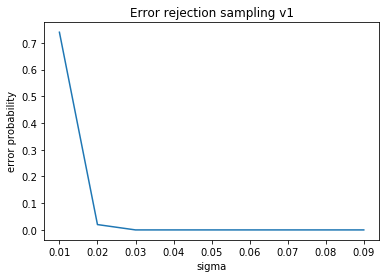

In [45]:
def error(sigma, n):
    cpt = 0
    for k in range(n):
        if type(rejection_sampling_fast(sigma, 10)) == int:
            cpt += 1
    return cpt/n

s = np.array([i/100 for i in range(1, 10)])
err = np.array([error(i, 50) for i in s])
plt.title("Error rejection sampling v1")
plt.xlabel("sigma")
plt.ylabel("error probability")
plt.plot(s, err)

On voit que pour sigma < 0.02 la probabilité que l'algo plante n'ets pas nulle, on va donc utiliser rejection sammpling long pour sigma < 0.03

No handles with labels found to put in legend.


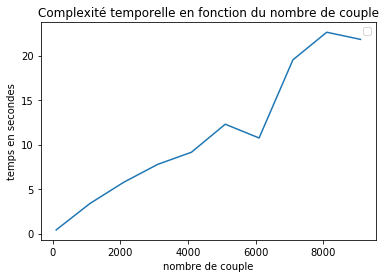

In [27]:
A = np.array([100 +1000*i for i in range(10)])
def time_rejection(sigma, n):
    s = time.time()
    R = rejection_sampling_4(sigma, n)
    e = time.time()
    return (e-s)

B = np.array([time_rejection(0.1, i) for i in A])
plt.title("Complexité temporelle en fonction du nombre de couple")
plt.xlabel("nombre de couple")
plt.ylabel("temps en secondes")
plt.legend()
plt.plot(A, B)
plt.show()

<ipython-input-62-6772392215fd>:11: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  plt.hist(H, bins=100, normed=True)


-18.042538018622974 17.945588873576046


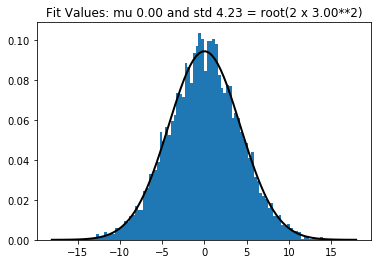

In [62]:
sigma = 3

R_4 = rejection_sampling_4(sigma, 10000)

H =[]
for k in range(10000):
    r = R_4[k]
    H.append(np.log(np.prod(np.exp(r))))


plt.hist(H, bins=100, normed=True)

xmin, xmax = plt.xlim()
print(xmin, xmax)
x = np.linspace(xmin, xmax, 100)
mu, std = norm.fit(np.array(H))
pdf = norm.pdf(x, mu, std)
plt.plot(x, pdf, 'k', linewidth=2)

title = "Fit Values: mu {:.2f} and std {:.2f} = root(2 x {:.2f}**2)".format(mu, std, sigma)
plt.title(title)
plt.show()

In [9]:

def _sample_parameter_r(n_samples, n_dim, sigma, random_state=None, n_jobs=1):
    """Sample the r parameters of a Riemannian Gaussian distribution.
    Sample the logarithm of the eigenvalues of a SPD matrix following a
    Riemannian Gaussian distribution.
    See https://arxiv.org/pdf/1507.01760.pdf for the mathematical details.
    Parameters
    ----------
    n_samples : int
        How many samples to generate.
    n_dim : int
        Dimensionality of the SPD matrices to be sampled.
    sigma : float
        Dispersion of the Riemannian Gaussian distribution.
    random_state : int, RandomState instance or None, default=None
        Pass an int for reproducible output across multiple function calls.
    n_jobs : int, default=1
        The number of jobs to use for the computation. This works by computing
        each of the class centroid in parallel. If -1 all CPUs are used.
    Returns
    -------
    r_samples : ndarray, shape (n_samples, n_dim)
        Samples of the r parameters of the Riemannian Gaussian distribution.
    """

    rs = check_random_state(random_state)
    x0 = rs.randn(n_dim)
    ptarget = partial(_pdf_r, sigma=sigma)
    r_samples = _slice_sampling(
        ptarget,
        n_samples=n_samples,
        x0=x0,
        random_state=random_state,
        n_jobs=n_jobs,
        )

    return r_samples













def _pdf_r(r, sigma):
    """Pdf for the log of eigenvalues of a SPD matrix.
    Probability deπnsity function for the logarithm of the eigenvalues of a SPD
    matrix samples from the Riemannian Gaussian distribution. See Said et al.
    "Riemannian Gaussian distributions on the space of symmetric positive
    definite matrices" (2017) for the mathematical details.
    Parameters
    ----------
    r : ndarray, shape (n_dim,)
        Vector with the logarithm of the eigenvalues of a SPD matrix.
    sigma : float
        Dispersion of the Riemannian Gaussian distribution.
    Returns
    -------
    p : float
        Probability density function applied to data point r.
    """

    if (sigma <= 0):
        raise ValueError(f'sigma must be a positive number (Got {sigma})')

    n_dim = len(r)
    partial_1 = -np.sum(r**2) / (2 * sigma**2)
    partial_2 = 0
    for i in range(n_dim):
        for j in range(i + 1, n_dim):
            partial_2 = partial_2 + np.log(np.sinh(np.abs(r[i] - r[j]) / 2))

    return np.exp(partial_1 + partial_2)



def _slice_sampling(ptarget, n_samples, x0, n_burnin=20, thin=10,
                    random_state=None, n_jobs=1):
    """Slice sampling procedure.
    Implementation of a slice sampling algorithm for sampling from any target
    pdf or a multiple of it. The implementation follows the description given
    in page 375 of David McKay's book "Information Theory, Inference, and
    Learning Algorithms" (2003).
    Parameters
    ----------
    ptarget : function with one input
        The target pdf to sample from or a multiple of it.
    n_samples : int
        How many samples to get from the ptarget distribution.
    x0 : array
        Initial state for the MCMC procedure. Note that the shape of this array
        defines the dimensionality n_dim of the data points to be sampled.
    n_burnin : int, default=20
        How many samples to discard from the beginning of the chain generated
        by the slice sampling procedure. Usually the first samples are prone to
        non-stationary behavior and do not follow very well the target pdf.
    thin : int, default=10
        Thinning factor for the slice sampling procedure. MCMC samples are
        often correlated between them, so taking one sample every `thin`
        samples can help reducing this correlation. Note that this makes the
        algorithm actually sample `thin x n_samples` samples from the pdf, so
        expect the whole sampling procedure to take longer.
    random_state : int, RandomState instance or None, default=None
        Pass an int for reproducible output across multiple function calls.
    n_jobs : int, default=1
        The number of jobs to use for the computation. This works by computing
        each of the class centroid in parallel. If -1 all CPUs are used.
    Returns
    -------
    samples : ndarray, shape (n_samples, n_dim)
        Samples from the target pdf.
    """

    if (n_samples <= 0) or (not isinstance(n_samples, int)):
        raise ValueError(
            f'n_samples must be a positive integer (Got {n_samples})')
    if (n_burnin <= 0) or (not isinstance(n_burnin, int)):
        raise ValueError(
            f'n_samples must be a positive integer (Got {n_burnin})')
    if (thin <= 0) or (not isinstance(thin, int)):
        raise ValueError(f'thin must be a positive integer (Got {thin})')

    rs = check_random_state(random_state)
    w = 1.0  # initial bracket width

    n_samples_total = (n_samples + n_burnin) * thin

    samples = Parallel(n_jobs=n_jobs)(
        delayed(_slice_one_sample)(ptarget, x0, w, rs)
        for _ in range(n_samples_total))

    samples = np.array(samples)[(n_burnin * thin):][::thin]

    return samples

def _slice_one_sample(ptarget, x0, w, rs):
    """Slice sampling for one sample
    Parameters
    ----------
    ptarget : function with one input
        The target pdf to sample from or a multiple of it.
    x0 : array
        Initial state for the MCMC procedure. Note that the shape of this array
        defines the dimensionality n_dim of the data points to be sampled.
    w : float
        Initial bracket width.
    rs : int, RandomState instance or None
        Pass an int for reproducible output across multiple function calls.
    Returns
    -------
    sample : ndarray, shape (n_dim,)
        Sample from the target pdf.
    """
    xt = np.copy(x0)
    n_dim = len(x0)

    for i in range(n_dim):

        ei = np.zeros(n_dim)
        ei[i] = 1

        # step 1 : evaluate ptarget(xt)
        Px = ptarget(xt)

        # step 2 : draw vertical coordinate uprime ~ U(0, ptarget(xt))
        uprime_i = Px * rs.rand()

        # step 3 : create a horizontal interval (xl_i, xr_i) enclosing xt_i
        r = rs.rand()
        xl_i = xt[i] - r * w
        xr_i = xt[i] + (1-r) * w
        while ptarget(xt + (xl_i - xt[i]) * ei) > uprime_i:
            xl_i = xl_i - w
        while ptarget(xt + (xr_i - xt[i]) * ei) > uprime_i:
            xr_i = xr_i + w

        # step 4 : loop
        while True:
            xprime_i = xl_i + (xr_i - xl_i) * rs.rand()
            Px = ptarget(xt + (xprime_i - xt[i]) * ei)
            if Px > uprime_i:
                break
            else:
                if xprime_i > xt[i]:
                    xr_i = xprime_i
                else:
                    xl_i = xprime_i

        # store coordinate i of new sample
        xt = np.copy(xt)
        xt[i] = xprime_i

    return xt


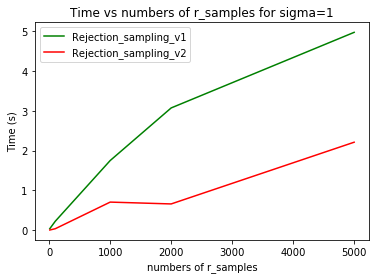

In [42]:
SIGMA = [1, 2, 3, 4, 5]
SIGMA2 = [0.1, 0.4, 0.8, 1]
N = [10, 100, 1000, 2000, 5000]

def time_slice(s, n):
    s2 = time.time()
    R = _sample_parameter_r(n, 2, s)
    e2 = time.time()
    return e2-s2

def time_reject(s,n):
    s1 = time.time()
    R2 = rejection_sampling_long(s, n)
    e1 = time.time()
    return e1 - s1

def time_rejec_2(s,n):
    s1 = time.time()
    R2 = rejection_sampling_fast(s, n)
    e1 = time.time()
    return e1 - s1

sig = 1

A = [time_reject(sig, n) for n in N]
B = [time_slice(sig, 50) for sig  in SIGMA]
C = [time_rejec_2(sig, n) for n in N]
plt.plot(N, A, 'g', label='Rejection_sampling_v1')
plt.plot(N, C, 'r', label='Rejection_sampling_v2')
#plt.plot(SIGMA, B, 'b', label='Slice_sampling')
plt.xlabel('numbers of r_samples')
plt.ylabel('Time (s)')
plt.title('Time vs numbers of r_samples for sigma=1')
plt.legend()
plt.show()

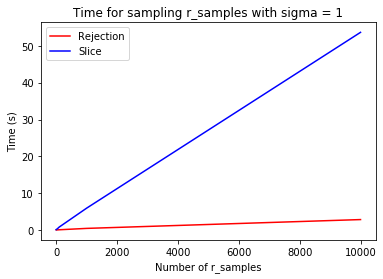

In [13]:
SIGMA = [0.01]
N = [1, 2, 10]

def time_slice(s, n):
    s2 = time.time()
    R = _sample_parameter_r(n, 2, s)
    e2 = time.time()
    return e2-s2

def time_reject(s,n):
    s1 = time.time()
    R2 = rejection_sampling(s, n)
    e1 = time.time()
    return e1 - s1

for sig in SIGMA:
    plt.figure()
    A = [time_reject(sig, n) for n in N]
    B = [time_slice(sig, n) for n in N]
    plt.subplot
    plt.plot(N, A, 'r', label='Rejection')
    plt.plot(N, B, 'b', label='Slice')
    plt.xlabel('Number of r_samples')
    plt.ylabel('Time (s)')
    plt.title('Time for sampling r_samples with sigma = ' + str(sig))
    plt.legend()
    plt.show()

L'algorithme de slice sampling est d'autant moins performant que la valeur de sigma est élevée. Ce qui n'est pas le cas pour le rejection sampling qui est lui, d'autant plus performant. (Environ 100 fois plus pour sigma=5 par exemple). De plus pour des valeurs de sigma très faibles (<0.01), le slice sampling ne converge tout simplement pas, alors que la disjonction de cas du rejection sampling lui permet de fonctionner dans tous les cas (même si l'algo qui permet la convergence dans le cas où sigma<0.01 est plus lent).